In [3]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import optuna
from sklearn.metrics import mean_absolute_error

In [ ]:
nome_produto = 'Sheet1'
base = pd.read_excel('../Data/base_vendas_pdv_IA.xlsx', sheet_name=nome_produto)

In [5]:
def create_features(df):
    df = df.sort_values(['PDV_ID','Data']).reset_index(drop=True)
    df['Ano'] = df['Data'].dt.year
    df['Mes'] = df['Data'].dt.month
    return df


def scaler_per_pdv(df, feature_cols):
    scalers = {}
    df_scaled = df.copy()
    for pdv, g in df.groupby('PDV_ID'):
        scaler = StandardScaler()
        df_scaled.loc[g.index, feature_cols] = scaler.fit_transform(g[feature_cols])
        scalers[pdv] = scaler
    return df_scaled, scalers

def make_sequences(df, pdv_id, feature_cols, target_col, seq_len):
    g = df[df['PDV_ID'] == pdv_id].sort_values('Data')
    X, y = [], []
    for i in range(len(g) - seq_len):
        X.append(g[feature_cols].iloc[i:i+seq_len].values)
        y.append(g[target_col].iloc[i+seq_len])  # next step target
    return np.array(X), np.array(y)

print('Funções definidas.')

Funções definidas.


In [6]:
# Modelo e função objetivo Optuna


def build_lstm_model(input_shape, n_units=64, dropout=0.2, lr=1e-3):
    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mae')
    return model

def objective_optuna(trial, X_train, y_train, X_val, y_val):
    n_units = trial.suggest_categorical('n_units', [32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16,32,64])
    # seq_len handled outside (rebuild sequences if needed)
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), n_units=n_units, dropout=dropout, lr=lr)
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=80, batch_size=batch_size, callbacks=[early], verbose=0)
    preds = model.predict(X_val).flatten()
    return mean_absolute_error(y_val, preds)

print('Modelo e função objetivo prontos.')

Modelo e função objetivo prontos.


In [ ]:
# Exemplo de pipeline resumido (não muito pesado)
from sklearn.model_selection import train_test_split
import optuna

# Carregar base
df = base
df = create_features(df)

feature_cols = ['Vendas','Custo','Lucro','Satisfacao','Mes']
target_col = 'Meta'

# Normalizar por PDV (exceto Mes)
df_scaled, scalers = scaler_per_pdv(df, ['Vendas','Custo','Lucro','Satisfacao'])

# Sequência padrão
DEFAULT_SEQ_LEN = 48

# Agregar sequências de todos os PDVs
Xs, ys = [], []
for pdv in df_scaled['PDV_ID'].unique():
    Xp, yp = make_sequences(df_scaled, pdv, feature_cols, target_col, seq_len=DEFAULT_SEQ_LEN)
    if len(Xp)>0:
        Xs.append(Xp); ys.append(yp)
X_all = np.vstack(Xs)
y_all = np.concatenate(ys)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.15, random_state=42, shuffle=True)

print('Shapes:', X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Rodar Optuna rápido de exemplo (aumente trials no seu ambiente)
def opt_obj(trial):
    return objective_optuna(trial, X_train, y_train, X_val, y_val)

study = optuna.create_study(direction='minimize')
print('Rodando Optuna (exemplo com 25 trials)...')
study.optimize(opt_obj, n_trials=25)

print('Melhor:', study.best_params)
best_params = study.best_params

[I 2025-09-10 18:26:49,295] A new study created in memory with name: no-name-3513c063-1348-4491-bff8-7afb3726a0ca


Shapes: (4865, 12, 5) (859, 12, 5) (4865,) (859,)
Rodando Optuna (exemplo com 25 trials)...


C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:27:28,412] Trial 0 finished with value: 1044.7452201567928 and parameters: {'n_units': 32, 'dropout': 0.10303306013057811, 'lr': 0.00013507686270239664, 'batch_size': 32}. Best is trial 0 with value: 1044.7452201567928.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:28:06,925] Trial 1 finished with value: 129.98577563391297 and parameters: {'n_units': 128, 'dropout': 0.23533610576059477, 'lr': 0.0024161200407405432, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:28:49,989] Trial 2 finished with value: 915.2972392249857 and parameters: {'n_units': 64, 'dropout': 0.30564206105156844, 'lr': 0.0002288440324246927, 'batch_size': 32}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:29:50,139] Trial 3 finished with value: 828.9936958854772 and parameters: {'n_units': 128, 'dropout': 0.08873504556741013, 'lr': 0.00016597545896948553, 'batch_size': 32}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:30:13,838] Trial 4 finished with value: 135.5551997519372 and parameters: {'n_units': 32, 'dropout': 0.08802061039788922, 'lr': 0.005512535488539947, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:30:43,017] Trial 5 finished with value: 710.3666649566401 and parameters: {'n_units': 64, 'dropout': 0.146926122990857, 'lr': 0.0009631020286600059, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:31:25,814] Trial 6 finished with value: 193.96671477099102 and parameters: {'n_units': 64, 'dropout': 0.28414721315924585, 'lr': 0.0011724039616588457, 'batch_size': 32}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:32:32,479] Trial 7 finished with value: 130.45510178873508 and parameters: {'n_units': 64, 'dropout': 0.18218188996882295, 'lr': 0.0007359603261832706, 'batch_size': 16}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:33:11,208] Trial 8 finished with value: 1003.2522737229939 and parameters: {'n_units': 32, 'dropout': 0.055621486489919936, 'lr': 0.00023937830834999232, 'batch_size': 32}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:33:30,399] Trial 9 finished with value: 130.03669058430043 and parameters: {'n_units': 128, 'dropout': 0.4168591692261373, 'lr': 0.006268354463079373, 'batch_size': 32}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:34:12,061] Trial 10 finished with value: 129.9876920838184 and parameters: {'n_units': 128, 'dropout': 0.43670152792159966, 'lr': 0.0025427965231315168, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:34:57,105] Trial 11 finished with value: 129.98668596296565 and parameters: {'n_units': 128, 'dropout': 0.4777651351603807, 'lr': 0.002336795073532502, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:35:42,715] Trial 12 finished with value: 129.98739551690738 and parameters: {'n_units': 128, 'dropout': 0.49763183537474126, 'lr': 0.002378178556942808, 'batch_size': 64}. Best is trial 1 with value: 129.98577563391297.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:36:30,929] Trial 13 finished with value: 129.9847623394754 and parameters: {'n_units': 128, 'dropout': 0.3404201760580855, 'lr': 0.0021351586195585623, 'batch_size': 64}. Best is trial 13 with value: 129.9847623394754.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:37:35,344] Trial 14 finished with value: 110.87038206444632 and parameters: {'n_units': 128, 'dropout': 0.3568653676481173, 'lr': 0.0037639224084247474, 'batch_size': 16}. Best is trial 14 with value: 110.87038206444632.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:38:30,470] Trial 15 finished with value: 110.69501463991105 and parameters: {'n_units': 128, 'dropout': 0.36981424675535834, 'lr': 0.00425716064801293, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:39:38,284] Trial 16 finished with value: 111.25649369156542 and parameters: {'n_units': 128, 'dropout': 0.3763141955715101, 'lr': 0.009089561841958813, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:40:42,897] Trial 17 finished with value: 110.9274965695258 and parameters: {'n_units': 128, 'dropout': 0.36330958258083224, 'lr': 0.004500480818596893, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:42:23,544] Trial 18 finished with value: 112.91312181963494 and parameters: {'n_units': 128, 'dropout': 0.22674275957618703, 'lr': 0.00046591480791464577, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:43:29,265] Trial 19 finished with value: 113.19117057329561 and parameters: {'n_units': 32, 'dropout': 0.4110771284173943, 'lr': 0.003982370775974453, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:44:03,064] Trial 20 finished with value: 112.02649120184263 and parameters: {'n_units': 128, 'dropout': 0.0033834892656410265, 'lr': 0.009868843029170425, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-09-10 18:45:10,513] Trial 21 finished with value: 110.99917770936409 and parameters: {'n_units': 128, 'dropout': 0.3607507931510769, 'lr': 0.0049404973112008735, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:46:15,528] Trial 22 finished with value: 111.7299304128165 and parameters: {'n_units': 128, 'dropout': 0.3147134980226835, 'lr': 0.004069697705018825, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:47:27,175] Trial 23 finished with value: 111.22635344286597 and parameters: {'n_units': 128, 'dropout': 0.26738923488466626, 'lr': 0.0015149013139401906, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.
C:\Users\José Orlei\AppData\Local\Temp\ipykernel_17028\2193859173.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-09-10 18:48:12,419] Trial 24 finished with value: 112.02492407766572 and parameters: {'n_units': 128, 'dropout': 0.387088970116457, 'lr': 0.003676792190018945, 'batch_size': 16}. Best is trial 15 with value: 110.69501463991105.


Melhor: {'n_units': 128, 'dropout': 0.36981424675535834, 'lr': 0.00425716064801293, 'batch_size': 16}


In [ ]:
def aplicar_regras_meta_smart(y_pred, meta_ant):
    """ Ajusta previsão conforme regras de negócio """
    min_val = meta_ant * 1.01   # pelo menos 1% acima
    max_val = meta_ant * 1.3    # no máximo 30% acima

    if y_pred < min_val:
        return min_val + 0.1 * (max_val - min_val)  # aproxima para dentro
    elif y_pred > max_val:
        return max_val - 0.1 * (max_val - min_val)  # aproxima para dentro
    else:
        return y_pred


def forecast_pdv_iterative(model, df_full, pdv_id, feature_cols, seq_len, steps=8, target_col="Meta"):
    g = df_full[df_full['PDV_ID'] == pdv_id].sort_values(by='Data').copy()
    last_seq = g[feature_cols].iloc[-seq_len:].values.copy()
    preds = []

    for step in range(steps):
        X_in = last_seq.reshape(1, seq_len, len(feature_cols))
        y_pred = model.predict(X_in, verbose=0).flatten()[0]

        # regra: comparar com a meta do ano anterior se existir
        if len(preds) > 0:
            meta_ant = preds[-1]  # último previsto vira referência
            y_pred = aplicar_regras_meta_smart(y_pred, meta_ant)

        preds.append(y_pred)

        # construir próximo row simples: shift and keep last features, increment month
        next_row = last_seq[-1].copy()
        next_row[feature_cols.index('Mes')] = (int(next_row[feature_cols.index('Mes')]) % 12) + 1
        last_seq = np.vstack([last_seq[1:], next_row])

    return preds


Epoch 1/100


C:\Users\José Orlei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


305/305 - 3s - 9ms/step - loss: 1021.7358 - val_loss: 927.7064
Epoch 2/100
305/305 - 1s - 4ms/step - loss: 855.4742 - val_loss: 762.5101
Epoch 3/100
305/305 - 1s - 4ms/step - loss: 689.1452 - val_loss: 597.3500
Epoch 4/100
305/305 - 1s - 4ms/step - loss: 523.8188 - val_loss: 432.4824
Epoch 5/100
305/305 - 1s - 4ms/step - loss: 361.0474 - val_loss: 271.5457
Epoch 6/100
305/305 - 1s - 4ms/step - loss: 223.4608 - val_loss: 164.6639
Epoch 7/100
305/305 - 1s - 4ms/step - loss: 161.9079 - val_loss: 134.8662
Epoch 8/100
305/305 - 1s - 4ms/step - loss: 144.3831 - val_loss: 130.2486
Epoch 9/100
305/305 - 1s - 4ms/step - loss: 142.6425 - val_loss: 130.0437
Epoch 10/100
305/305 - 1s - 4ms/step - loss: 141.1537 - val_loss: 130.1689
Epoch 11/100
305/305 - 1s - 4ms/step - loss: 142.3736 - val_loss: 130.5233
Epoch 12/100
305/305 - 1s - 4ms/step - loss: 142.7369 - val_loss: 130.4765
Epoch 13/100
305/305 - 1s - 4ms/step - loss: 142.9308 - val_loss: 130.3675
Epoch 14/100
305/305 - 1s - 4ms/step - loss: 

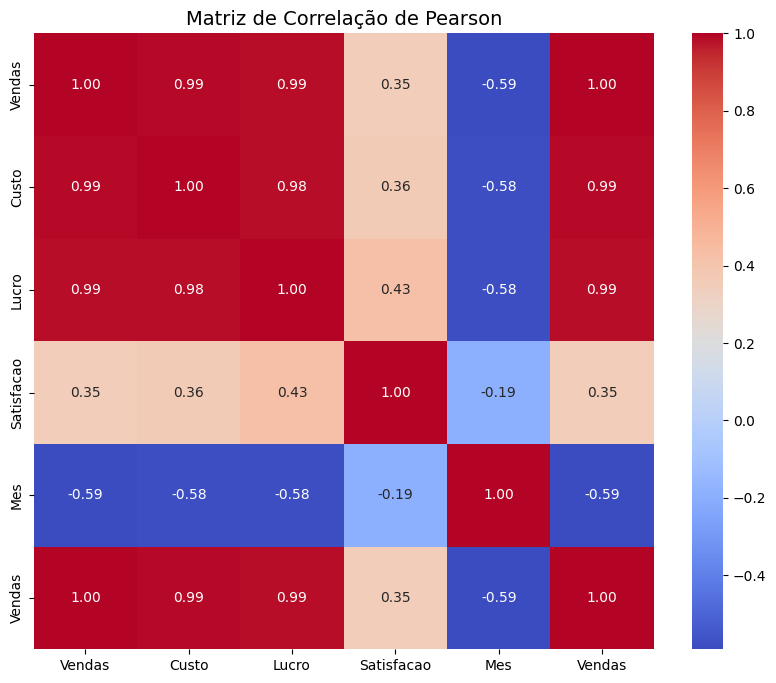

📊 Variáveis mais correlacionadas com Vendas
Custo         0.992841
Lucro         0.987197
Satisfacao    0.352963
Mes          -0.591025
Name: Vendas, dtype: float64


In [13]:
# 🔎 Matriz de correlação de Pearson e variáveis mais importantes
import seaborn as sns

# Calcula a correlação apenas para colunas numéricas
corr = df_scaled[feature_cols + ['Vendas']].corr(method='pearson')

# Plot do heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação de Pearson", fontsize=14)
plt.show()

# Ordena variáveis mais correlacionadas com Vendas
target = 'Vendas'

# Força o resultado a ser uma Series (linha/coluna da matriz de correlação)
corr_target = corr[target]

# Se vier como DataFrame, converte para Series
if isinstance(corr_target, pd.DataFrame):
    corr_target = corr_target.iloc[:, 0]

# Remove a autocorrelação
corr_target = corr_target.drop(labels=[target])

# Ordena por valor
corr_target = corr_target.sort_values(ascending=False)

print("📊 Variáveis mais correlacionadas com", target)
print(corr_target)



In [ ]:

# regra de negocio, meta maior que a anterior
# meta nao ser maior que a meta anterior x1.5